In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import random
import xgboost as xgb
from collections import defaultdict
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor


def calculate_features(df, slope_multiplier, lowest_point_range, time_interval):
    result_df = pd.DataFrame(columns=['Lowest_Current_Value', 'Rise_Slope', 'Lowest_Point_Time', 'Lifetime'])
    all_points = []

    for column in df.columns:  # 遍历每一列（假设所有列都是电流数据）
        current_data = df[column].dropna().reset_index(drop=True)

        # 生成时间列，并转换为小时
        aging_time = np.arange(len(current_data)) * time_interval
        current_data = pd.DataFrame({'老化时间': aging_time, column: current_data})

        # 在第10到lowest_point_range个数据点中寻找连续5个值的平均值最小的点
        limited_current_data = current_data[9:lowest_point_range]
        rolling_means = limited_current_data[column].rolling(window=5).mean().dropna()
        min_mean_idx = rolling_means.idxmin() if not rolling_means.empty else None

        if min_mean_idx is not None and min_mean_idx in limited_current_data.index:
            # 使用连续5个值的平均值最小的点作为最低点
            min_mean_idx = int(min_mean_idx)
            lowest_point_time = current_data.at[min_mean_idx + 2, '老化时间']  # 使用5个点中的中间点
            lowest_current_value = current_data.at[min_mean_idx + 2, column]
            lifetime = current_data['老化时间'].max()

            # 确定观察时间段
            end_time_point = lowest_point_time * slope_multiplier
            observation_period = current_data[(current_data['老化时间'] > lowest_point_time) & (current_data['老化时间'] <= end_time_point)]

            if len(observation_period) >= 2:
                # 准备线性回归的输入数据
                X = observation_period[['老化时间']].values.reshape(-1, 1)
                y = observation_period[column].values

                # 使用线性回归模型计算电流上升斜率
                model = LinearRegression()
                model.fit(X, y)
                slope = model.coef_[0]  # 提取斜率

            else:
                slope = np.nan  # 数据点不足，斜率设为 NaN

            new_row = pd.DataFrame({
                'Lowest_Current_Value': [lowest_current_value],
                'Rise_Slope': [slope],
                'Lowest_Point_Time': [lowest_point_time],
                'Lifetime': [lifetime]
            })
            result_df = pd.concat([result_df, new_row], ignore_index=True)
            all_points.append((current_data, lowest_point_time, lowest_current_value))

    return result_df, all_points

def optimize_model(X_train, y_train, model_type='random_forest'):
    if model_type == 'random_forest':
        param_grid = {
            'n_estimators': [40, 50, 100, 200, 300, 500],
            'max_depth': [3, 4, 5, 7, 10, 12],
        }
        model = RandomForestRegressor(random_state=42)
    elif model_type == 'gbdt':
        param_grid = {
            'n_estimators': [40, 50, 60, 70, 80, 100, 150, 200, 300, 500],
            'max_depth': [1, 2, 3],
            'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2, 0.3],
        }
        model = GradientBoostingRegressor(random_state=42)
    elif model_type == 'xgboost':
        param_grid = {
            'n_estimators': [40, 50, 60, 70, 80, 100, 150, 200, 300, 500],
            'max_depth': [1, 2, 3],
            'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5],
        }
        model = xgb.XGBRegressor(random_state=42, use_label_encoder=False, eval_metric='rmse')
    elif model_type == 'svr':
        param_grid = {
            'C': [0.1, 1, 10, 100],
            'epsilon': [0.01, 0.05, 0.1, 0.2],
            
        }
        model = SVR()
    elif model_type == 'ann':
        param_grid = {
            'hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 100)],
            
            'learning_rate_init': [0.001, 0.01, 0.05],
        }
        model = MLPRegressor(max_iter=1000, random_state=42)

    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_

def evaluate_model(features_df, model_type, n_runs):
    # 提取特征和目标变量
    X = features_df[['Lowest_Current_Value', 'Rise_Slope', 'Lowest_Point_Time']]
    y = features_df['Lifetime']

    mse_list = []
    r2_list = []
    best_params_count = defaultdict(int)  # 用于记录每种最佳参数组合出现的次数
    best_params_r2 = defaultdict(list)  # 用于记录每种最佳参数组合的R²分数

    # 多次运行，通过不同的随机种子分割数据
    for random_seed in range(n_runs):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

        # 优化模型并记录最佳参数
        model, best_params, best_score = optimize_model(X_train, y_train, model_type)
        best_params_tuple = tuple(best_params.items())
        best_params_count[best_params_tuple] += 1  # 将最佳参数组合转换为元组并记录出现次数
        best_params_r2[best_params_tuple].append(best_score)

        # 预测并评估模型性能
        y_pred = model.predict(X_test)
        mse_list.append(mean_squared_error(y_test, y_pred))
        r2_list.append(r2_score(y_test, y_pred))

    # 选择出现频率最高的最佳参数组合
    max_count = max(best_params_count.values())
    candidates = [params for params, count in best_params_count.items() if count == max_count]
    
    if len(candidates) > 1:
        # 如果有多个参数组合的出现次数相同，则选择平均R²最高的参数组合
        best_params = max(candidates, key=lambda params: np.mean(best_params_r2[params]))
    else:
        best_params = candidates[0]
    
    best_params = dict(best_params)
    best_params_count_value = best_params_count[tuple(best_params.items())]  # 获取最佳参数组合的出现次数
    
    # 返回平均均方误差、平均R2分数、最佳参数和最佳参数的出现次数
    return np.mean(mse_list), np.mean(r2_list), best_params, best_params_count_value


def plot_curves(all_points, num_samples=10):
    if len(all_points) > num_samples:
        all_points = random.sample(all_points, num_samples)

    for i, (current_data, lowest_point_time, lowest_current_value) in enumerate(all_points):
        plt.figure(figsize=(10, 6))
        plt.plot(current_data['老化时间'], current_data.iloc[:, 1], label=f'Sample {i + 1}')
        plt.scatter(lowest_point_time, lowest_current_value, color='red', label='Lowest Point')
        plt.xlabel('Aging Time (hours)')
        plt.ylabel('Current (uA)')
        plt.title(f'Current vs. Time for Sample {i + 1}')
        plt.legend()
        plt.show()

# 从Excel文件中读取数据
df = pd.read_excel('time_series.xlsx')

# 设置参数
lowest_point_range = 20000
time_interval = 30 / 3600

# 网格搜索 slope_multiplier
slope_multipliers = np.arange(2.5, 3, 0.1)

results = {
    'slope_multiplier': [],
    'model': [],
    'mse': [],
    'r2': [],
    'best_params': [],
    'best_params_count': []
}

for slope_multiplier in slope_multipliers:
    features_df, _ = calculate_features(df, slope_multiplier, lowest_point_range, time_interval)
    
    for model_type in ['random_forest', 'gbdt', 'xgboost', 'svr', 'ann']:
        mse, r2, params,best_params_count = evaluate_model(features_df, model_type, n_runs=20)
        
        results['slope_multiplier'].append(slope_multiplier)
        results['model'].append(model_type)
        results['mse'].append(mse)
        results['r2'].append(r2)
        results['best_params'].append(params)
        results['best_params_count'].append(best_params_count)

# 保存评估结果到 Excel 文件
results_df = pd.DataFrame(results)
results_df.to_excel('model_evaluation_results.xlsx', index=False)





KeyboardInterrupt: 

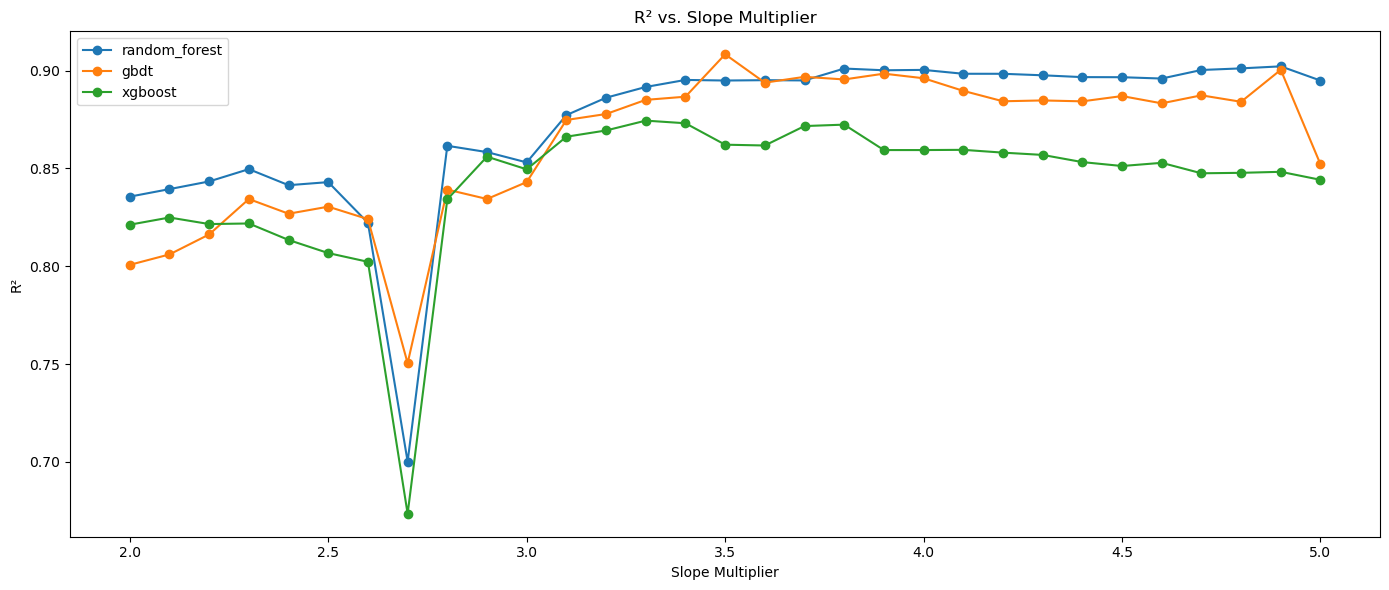

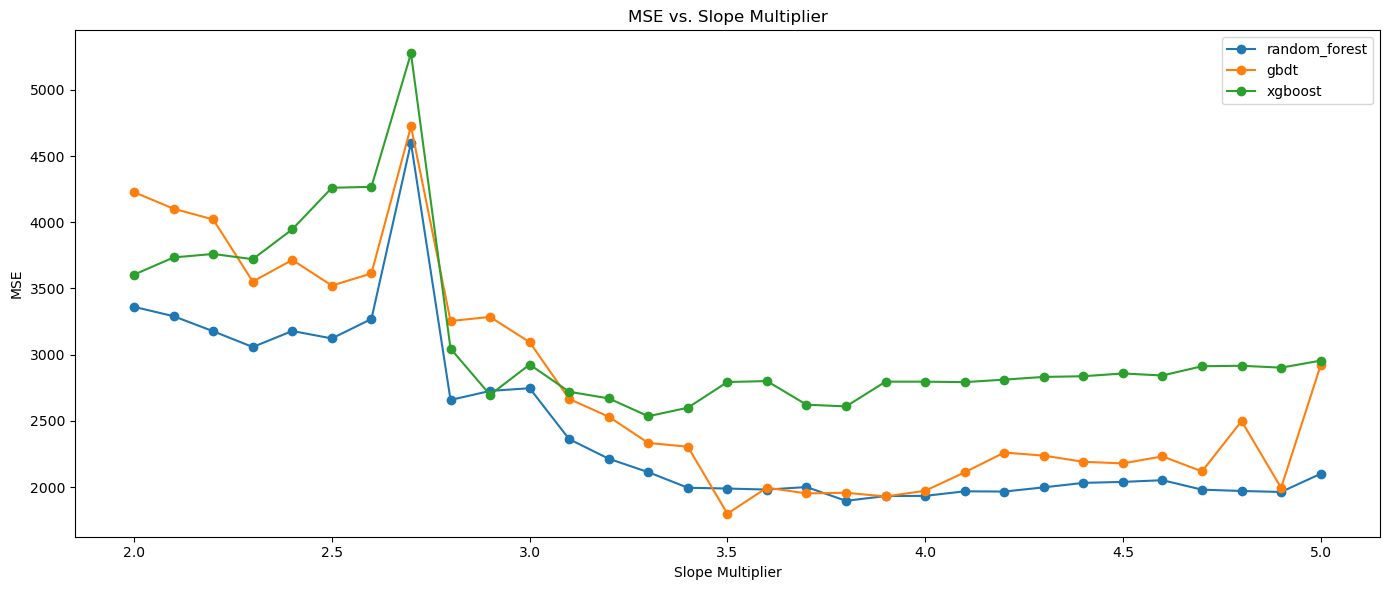

In [ ]:
# 绘制 R² 随 slope_multiplier 的变化图
plt.figure(figsize=(14, 6))
for model_type in ['random_forest', 'gbdt', 'xgboost', 'svr', 'ann']:
    model_results = results_df[results_df['model'] == model_type]
    plt.plot(model_results['slope_multiplier'], model_results['r2'], marker='o', label=model_type)

plt.title('R² vs. Slope Multiplier')
plt.xlabel('Slope Multiplier')
plt.ylabel('R²')
plt.legend()
plt.tight_layout()
plt.show()

# 绘制 MSE 随 slope_multiplier 的变化图
plt.figure(figsize=(14, 6))
for model_type in ['random_forest', 'gbdt', 'xgboost', 'svr', 'ann']:
    model_results = results_df[results_df['model'] == model_type]
    plt.plot(model_results['slope_multiplier'], model_results['mse'], marker='o', label=model_type)

plt.title('MSE vs. Slope Multiplier')
plt.xlabel('Slope Multiplier')
plt.ylabel('MSE')
plt.legend()
plt.tight_layout()
plt.show()